# 👩🏼‍🚒 Training a Rockpool network with Torch

In [1]:
# -- Some useful imports

# - Rich printinghttp://localhost:8888/notebooks/torch-training.ipynb#
try:
    from rich import print
except:
    pass

# - Numpy
import numpy as np

# - Import and configure matplotlib for plotting
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 4]
plt.rcParams['figure.dpi'] = 300

## Considerations when using Torch

``Torch`` is a very popular and easy to use machine learning library including a vast number of features.
In ``Rockpool`` we want to make sure that our users have access to all the power provided by ``Torch`` in a nearly native way while also having access to the functionality provided by all other backends and ``Rockpool`` itself.

``Torch`` can be used in two ways. First, an existing ``PyTorch`` model can be converted to work with the ``Rockpool`` API using the :py:meth:`.TorchModule.from_torch` function. Second, a model ``in Torch`` can be written in scratch using the :py:meth:`.TorchModule` class. For details see: :ref:`/in-depth/torch-api.ipynb`.

This notebook shows how to define a model using the ``TorchModule`` class and train it on a simple task. For comparibility, the used examples in this notebook are the same as in :ref:`/in-depth/jax-training.ipynb`

## Define a task

We will define a simple random regression task, where random frozen input noise is mapped to randomly chosen smooth output signals. We implement this using a ``Dataset``-compatible class, implementing the ``__len__()`` and ``__getitem__()`` methods.

In [2]:
import torch

# - Define a dataset class implementing the indexing interface
class MultiClassRandomSinMapping:
    def __init__(self,
                 num_classes: int = 2,
                 sample_length: int = 100,
                 input_channels: int = 50,
                 target_channels: int = 2):
        # - Record task parameters
        self._num_classes = num_classes
        self._sample_length = sample_length
        
        # - Draw random input signals
        self._inputs = np.random.randn(num_classes, sample_length, input_channels) + 1.
        
        # - Draw random sinusoidal target parameters
        self._target_phase = np.random.rand(num_classes, 1, target_channels) * 2 * np.pi
        self._target_omega = np.random.rand(num_classes, 1, target_channels) * sample_length / 50
        
        # - Generate target output signals
        time_base = np.atleast_2d(np.arange(sample_length) / sample_length).T
        self._targets = np.sin(2 * np.pi * self._target_omega * time_base + self._target_phase)
    
    def __len__(self):
        # - Return the total size of this dataset
        return self._num_classes
    
    def __getitem__(self, i):
        # - Return the indexed dataset sample
        return torch.Tensor(self._inputs[i]), torch.Tensor(self._targets[i])

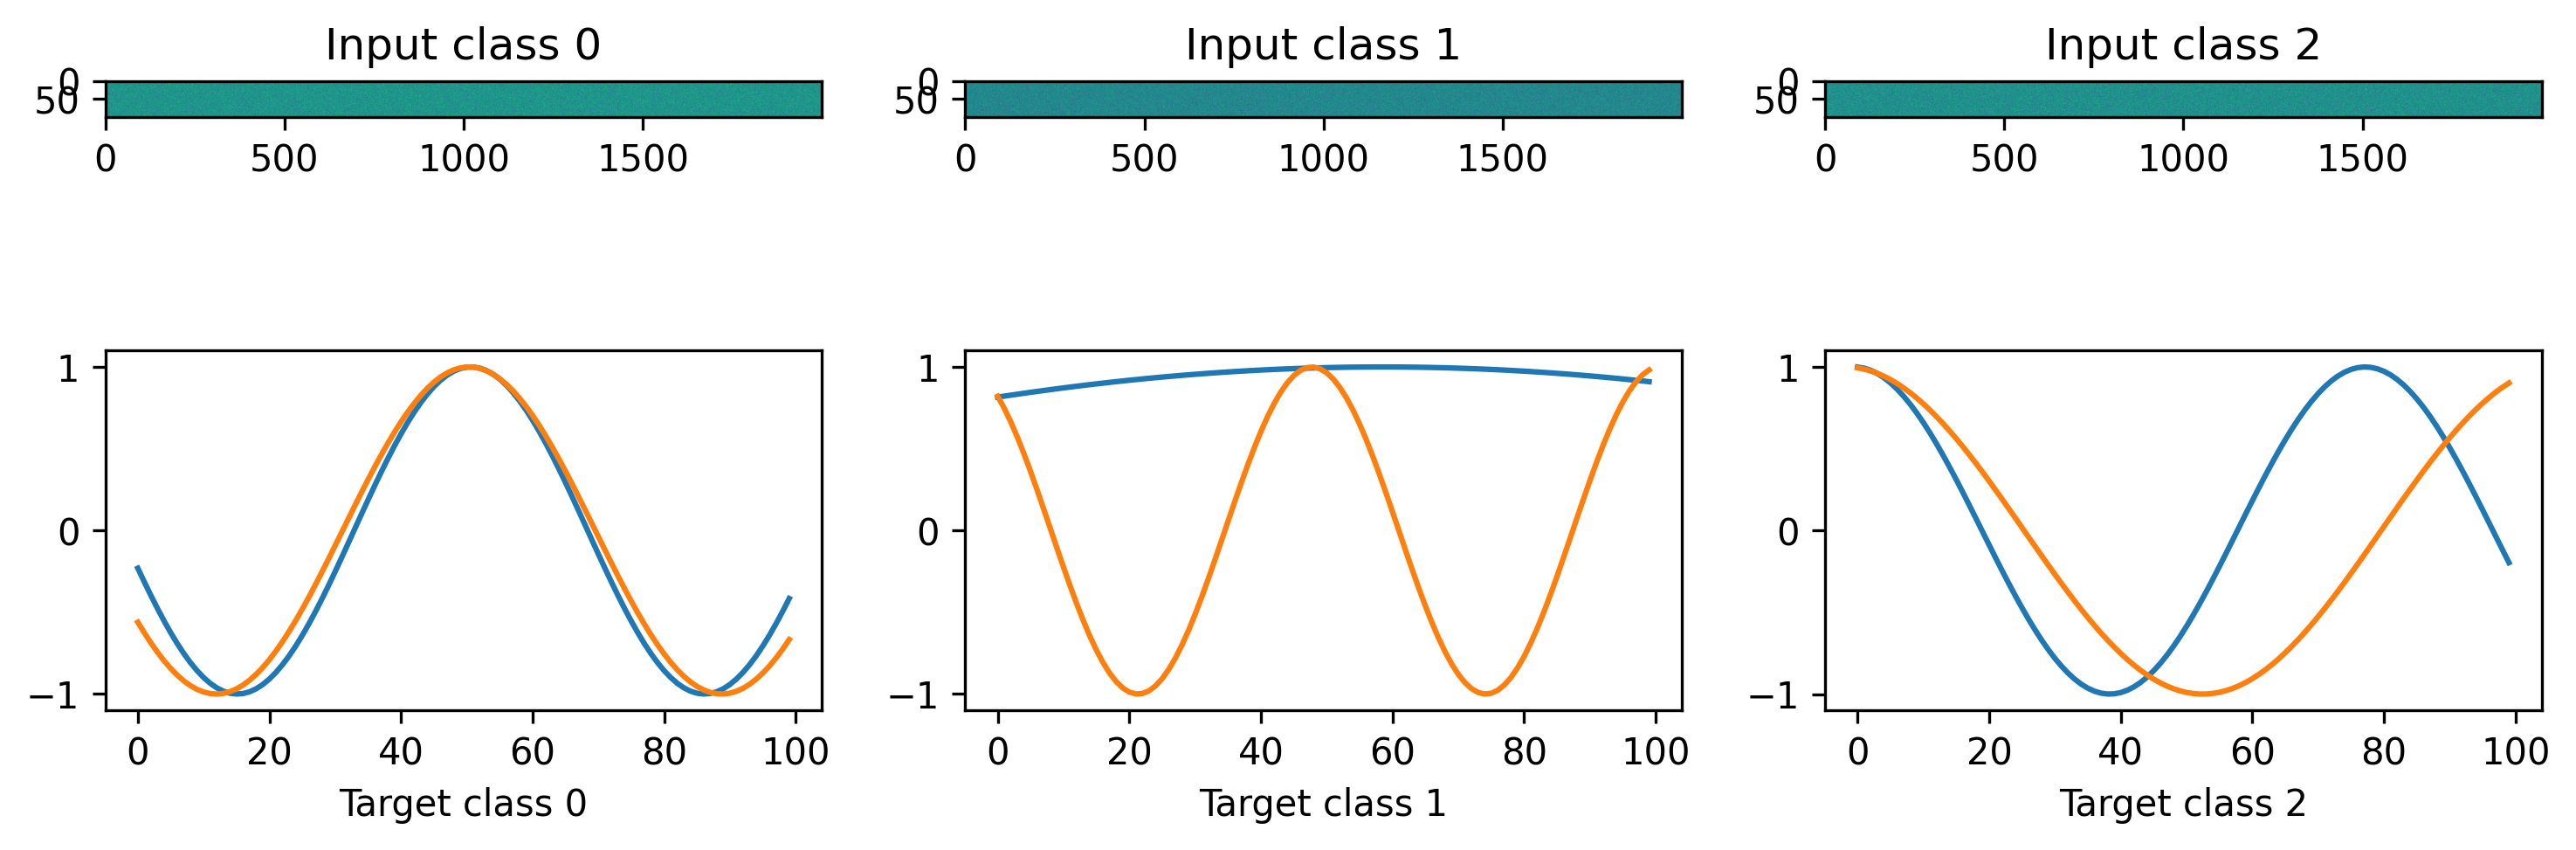

In [3]:
# - Instantiate a dataset
Nin = 2000
Nout = 2
num_classes = 3
T = 100
ds = MultiClassRandomSinMapping(num_classes = num_classes,
                                input_channels = Nin,
                                target_channels = Nout,
                                sample_length = T,
                               )

# Display the dataset classes
plt.figure()
for i, sample in enumerate(ds):
    plt.subplot(2, len(ds), i + 1)
    plt.imshow(sample[0])
    plt.title(f'Input class {i}')
    
    plt.subplot(2, len(ds), i + len(ds) + 1)
    plt.plot(sample[1])
    plt.xlabel(f'Target class {i}')

## Defining a network

We'll define a very simple MLP-like network to solve the regression task we just defined. In this simple network we define one hidden layer with a tanh non-linearity.

In [4]:
from torch.nn import Linear, Tanh
from rockpool.nn.modules.torch.torch_module import TorchModule
import copy

class SimpleNet(TorchModule):
    def __init__(self,
                 Nin,
                 Nhidden,
                 Nout):
        super().__init__()
        self.lin_in = Linear(Nin, Nhidden)
        self.tanh = Tanh()
        self.lin_out = Linear(Nhidden, Nout)
        
    def forward(self, inp):
        out = self.lin_out(self.tanh(self.lin_in(inp)))
        return out
    
    def torch_params(self):
        return torch.nn.Module.parameters(self)

/home/philipp/.pyenv/versions/3.8.7/envs/rockpool/lib/python3.8/site-packages/rockpool/utilities/__init__.py:68: UserWarning: Could not load package .timedarray_shift
  warn("Could not load package " + strModule)
/home/philipp/.pyenv/versions/3.8.7/envs/rockpool/lib/python3.8/site-packages/rockpool/nn/layers/__init__.py:79: UserWarning: Could not load package .iaf_brian
  warn("Could not load package " + strModule)


'Brian2' backend not found. Modules that rely on Brian will not be available.
'Brian2'backend not found. Modules that rely on Brian will not be available.
'Brian2' backend not found. Modules that rely on Brian will not be available.


/home/philipp/.pyenv/versions/3.8.7/envs/rockpool/lib/python3.8/site-packages/rockpool/nn/layers/__init__.py:79: UserWarning: Could not load package .exp_synapses_brian
  warn("Could not load package " + strModule)


In [5]:
Nhidden = 800
net = SimpleNet(Nin, Nhidden, Nout)

## Training loop

As usually done for a regression task, we are using the MSE loss and Adam during training.
The whole workflow is very similar to the native ``Torch`` API. The one difference to the standard ``Torch`` API is that the forward function returns a tuple of `(output, state, recordings)`.

In [6]:
# - Useful imports
from tqdm.autonotebook import tqdm
from torch.optim import Adam
from torch.nn import MSELoss

# - Get the optimiser functions
optimizer = Adam(net.torch_params(), lr=1e-4)

# - Loss function
loss_fun = MSELoss()

# - Record the loss values over training iterations
loss_t = []

num_epochs = 100

# - Loop over iterations
for _ in tqdm(range(num_epochs)):
    for input, target in ds:

        optimizer.zero_grad()
                
        output, state, recordings = net(input)
        
        loss = loss_fun(output, target)
        loss.backward()
        optimizer.step()
               
        # - Keep track of the loss
        loss_t.append(loss.item())

  0%|          | 0/100 [00:00<?, ?it/s]

After training for 100 epochs, we inspect the loss and plot the result of the training. We can see that the loss is decreasing and the predicted curves match the target curves nicely.

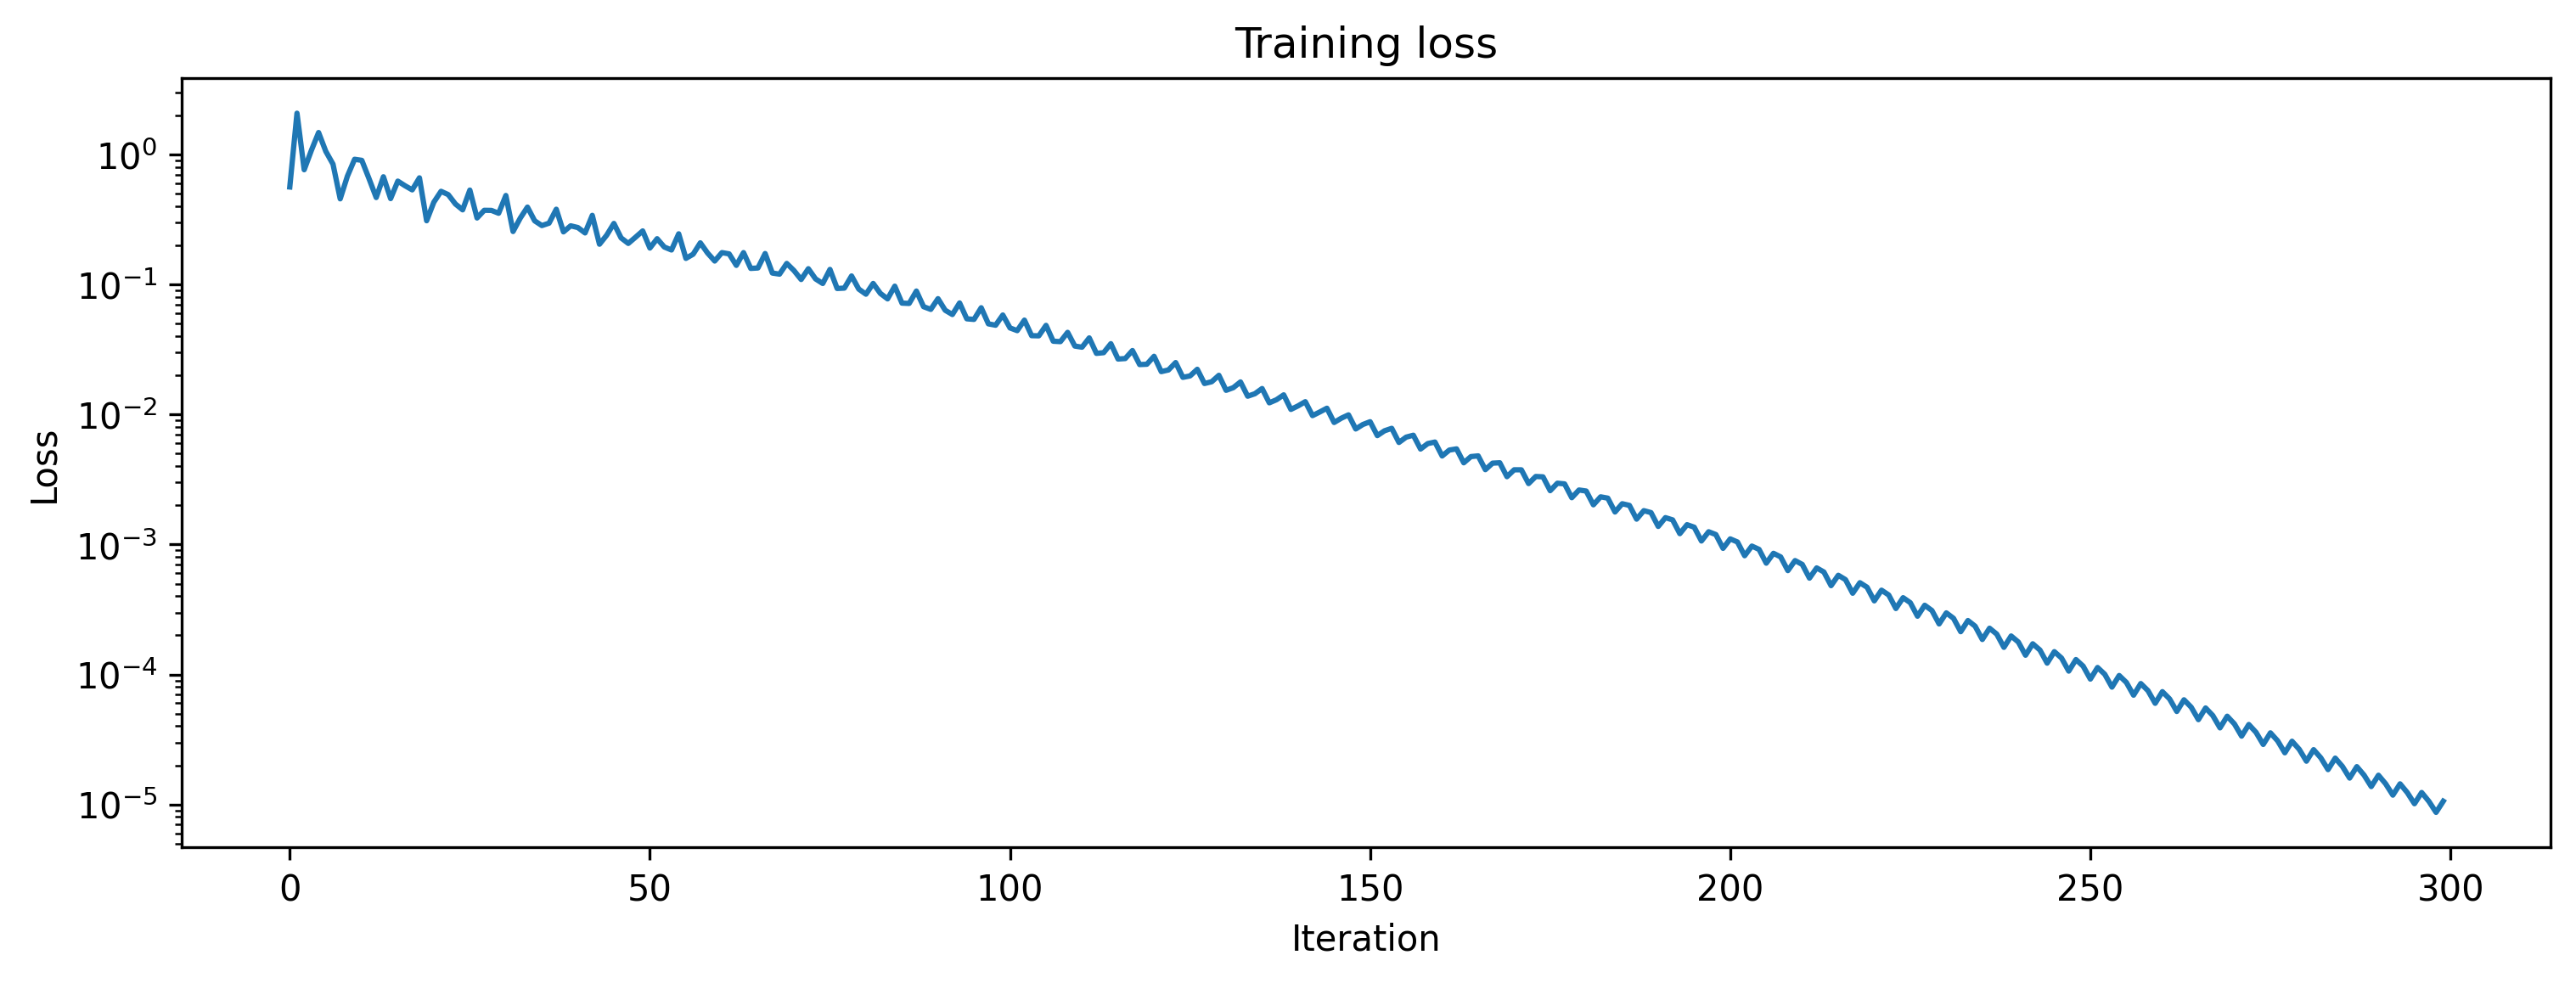

In [7]:
# - Plot the loss over iterations
plt.plot(loss_t)
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training loss');

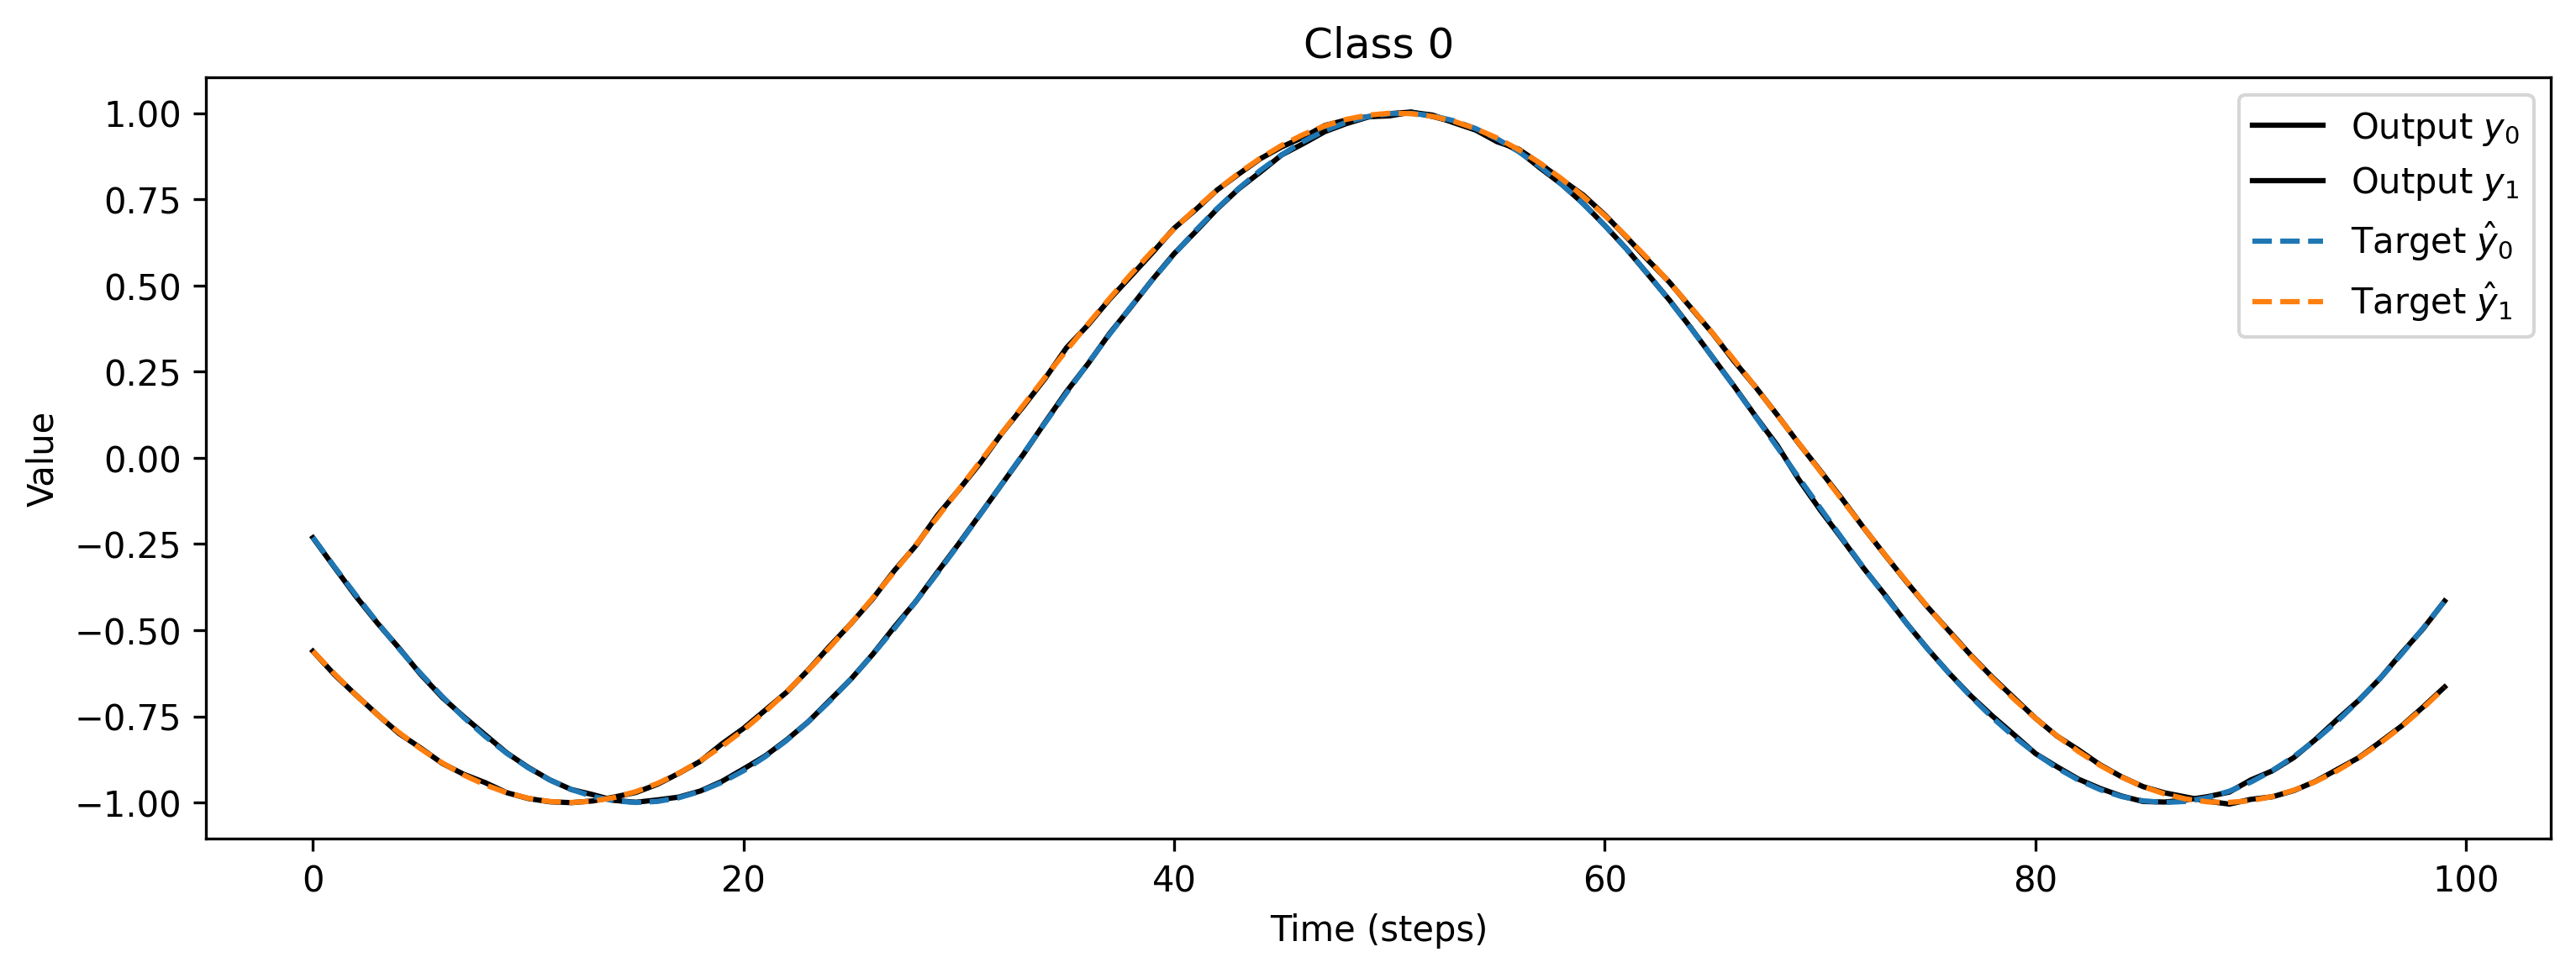

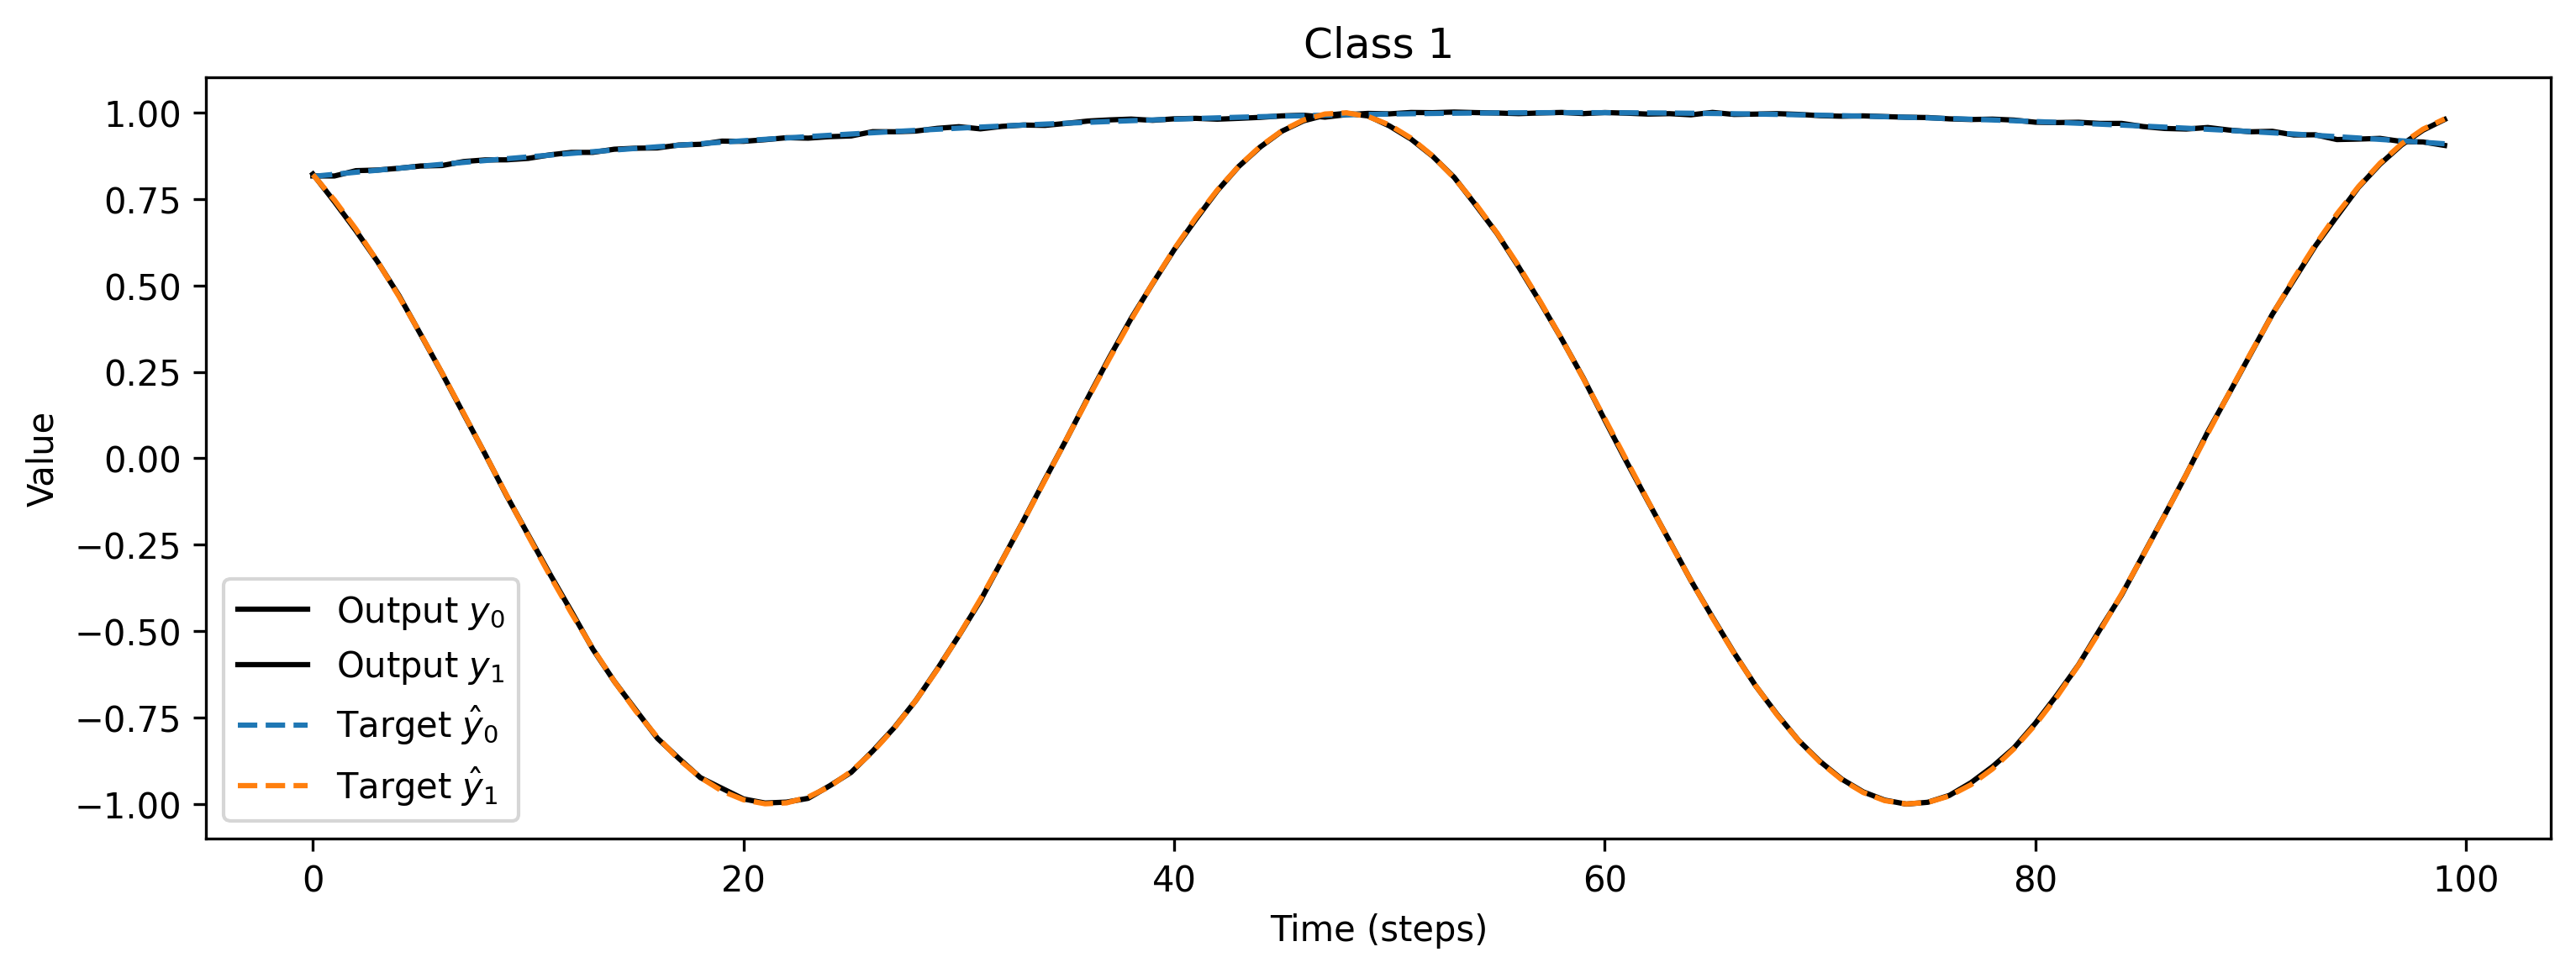

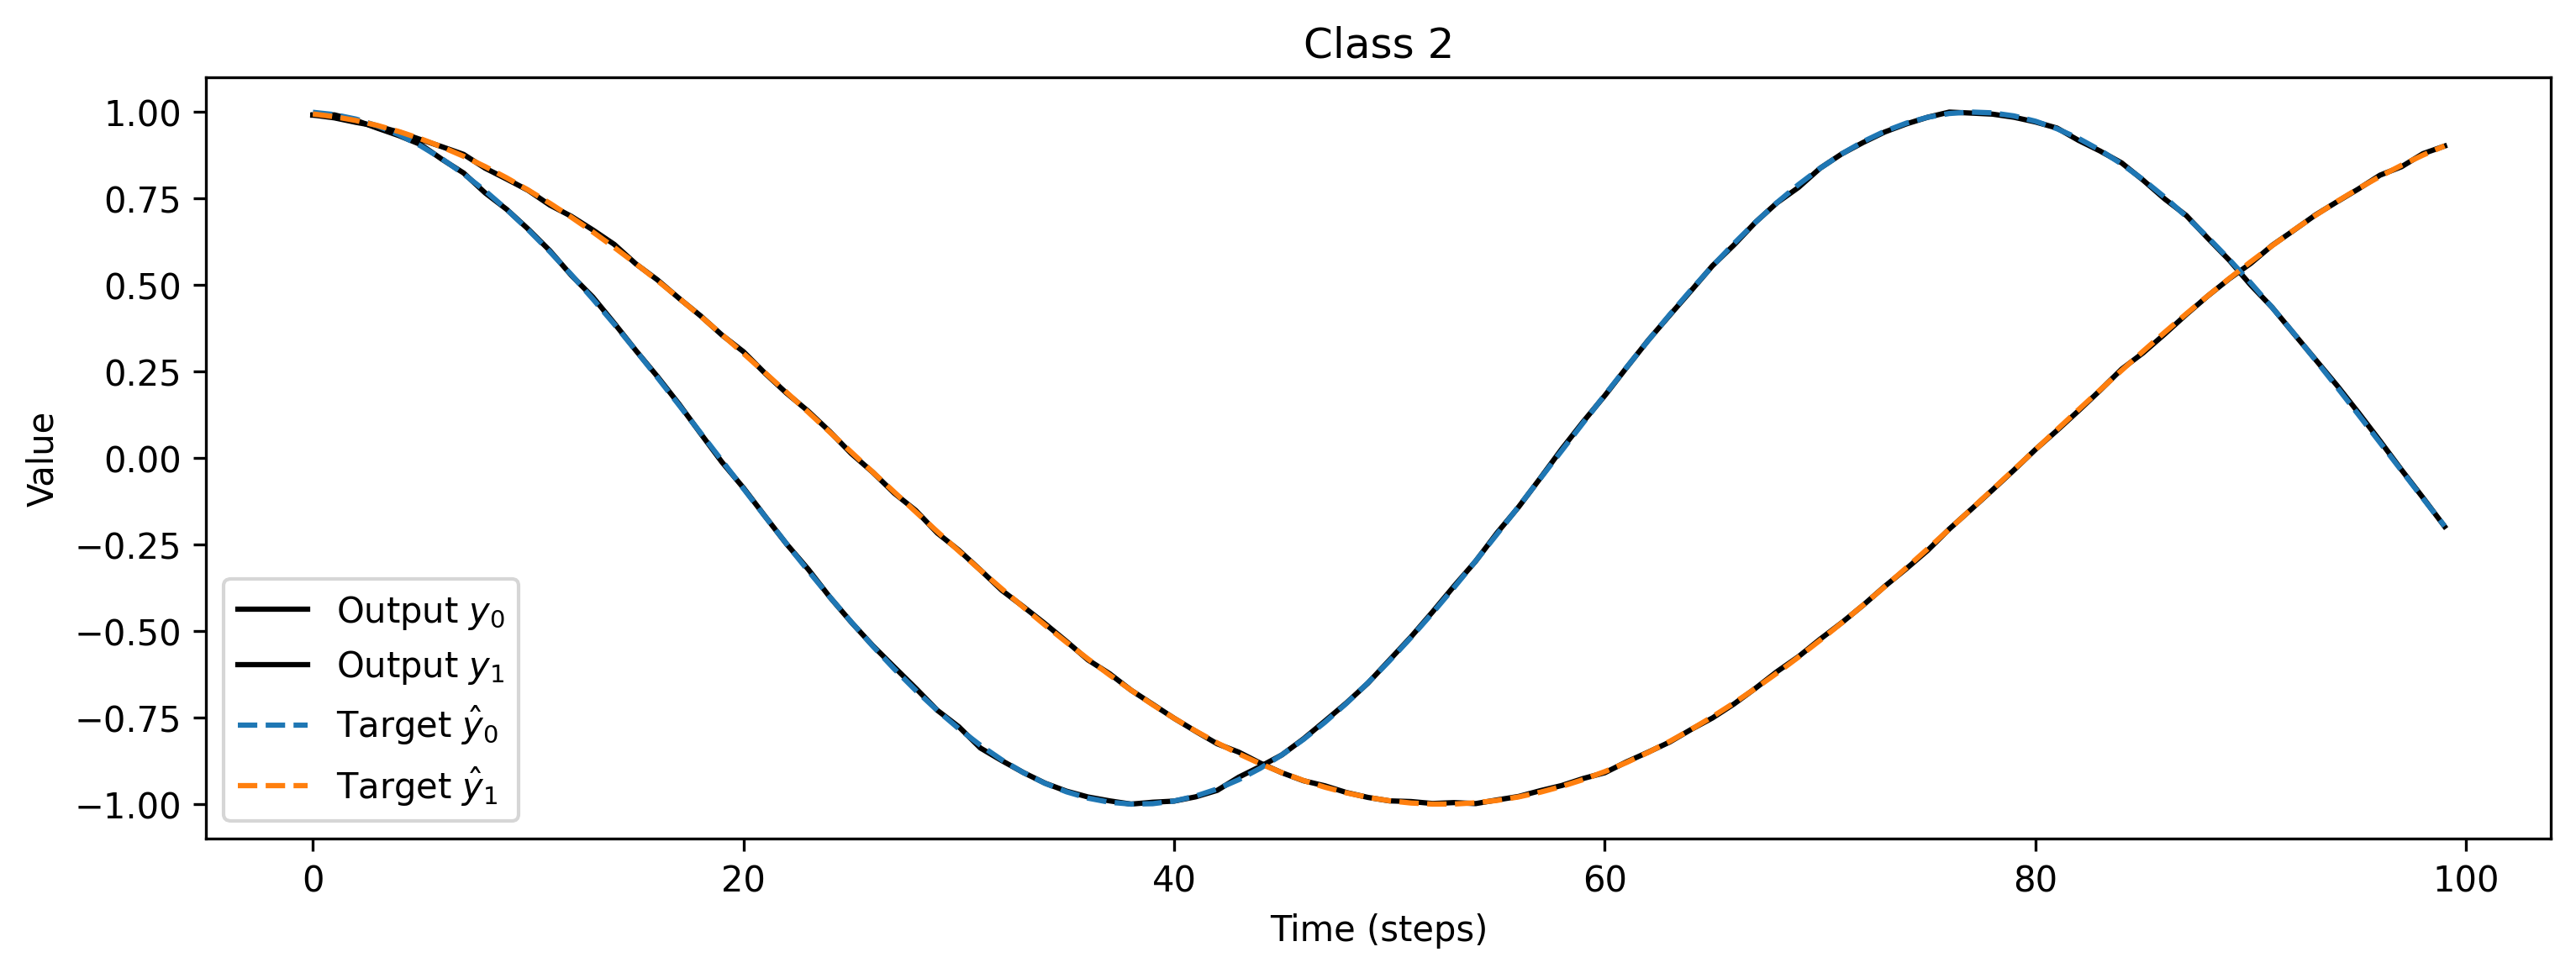

In [8]:
# - Evaluate classes
for i_class, [input, target] in enumerate(ds):
    
    # - Evaluate network
    net = net.reset_state()
    output, _, _ = net(input, record = True)
    
    # - Plot output and target
    plt.figure()
    plt.plot(output.detach().cpu().numpy(), 'k-')
    plt.plot(target, '--')
    plt.xlabel('Time (steps)')
    plt.ylabel('Value')
    plt.legend(['Output $y_0$',
                'Output $y_1$',
                'Target $\hat{y}_0$',
                'Target $\hat{y}_1$',
               ])
    plt.title(f'Class {i_class}')